### CTCL object

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
#import loompy
import matplotlib as mpl
import harmonypy as hm

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()


In [3]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_raw_rmdou.h5ad'
adata = sc.read_h5ad(input_file)

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

filtered out 2147 cells that have less than 200 genes expressed
filtered out 5587 genes that are detected in less than 3 cells


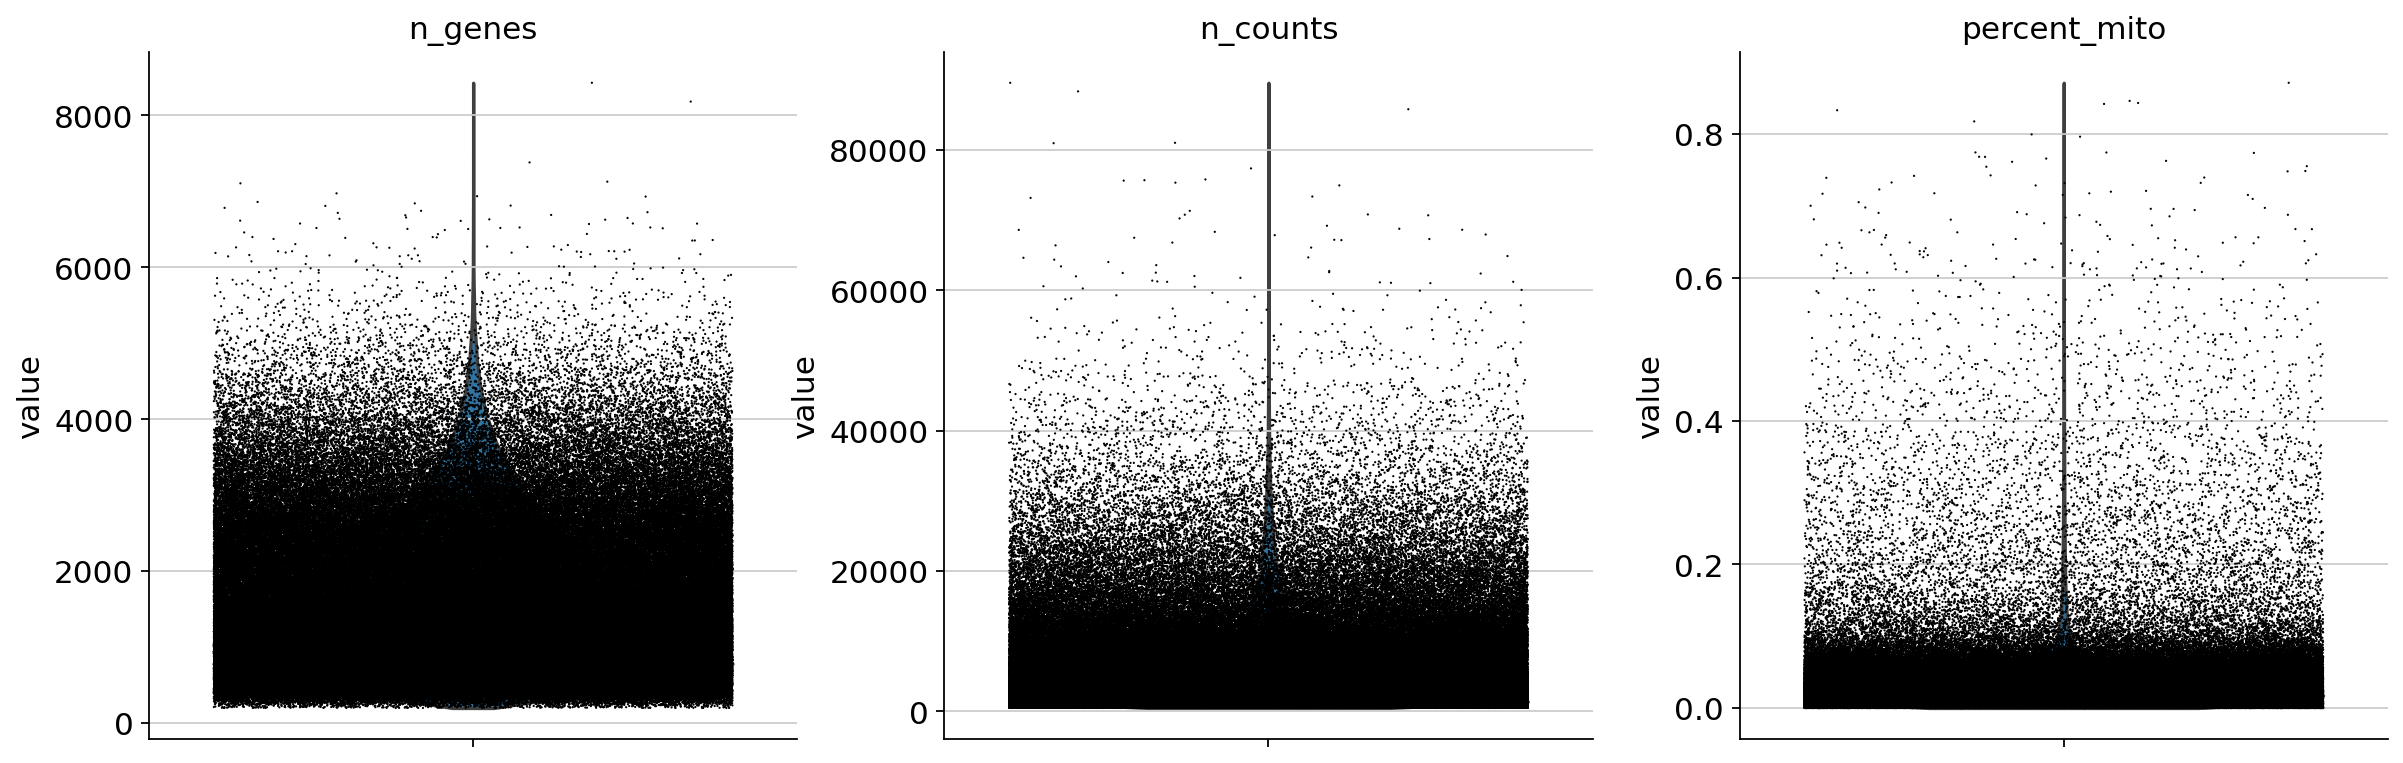

In [5]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [6]:
adata = adata[adata.obs['percent_mito'] < 0.2, :]

In [7]:
#adata_backup_raw = adata.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)
adata.raw = adata


normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:09): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


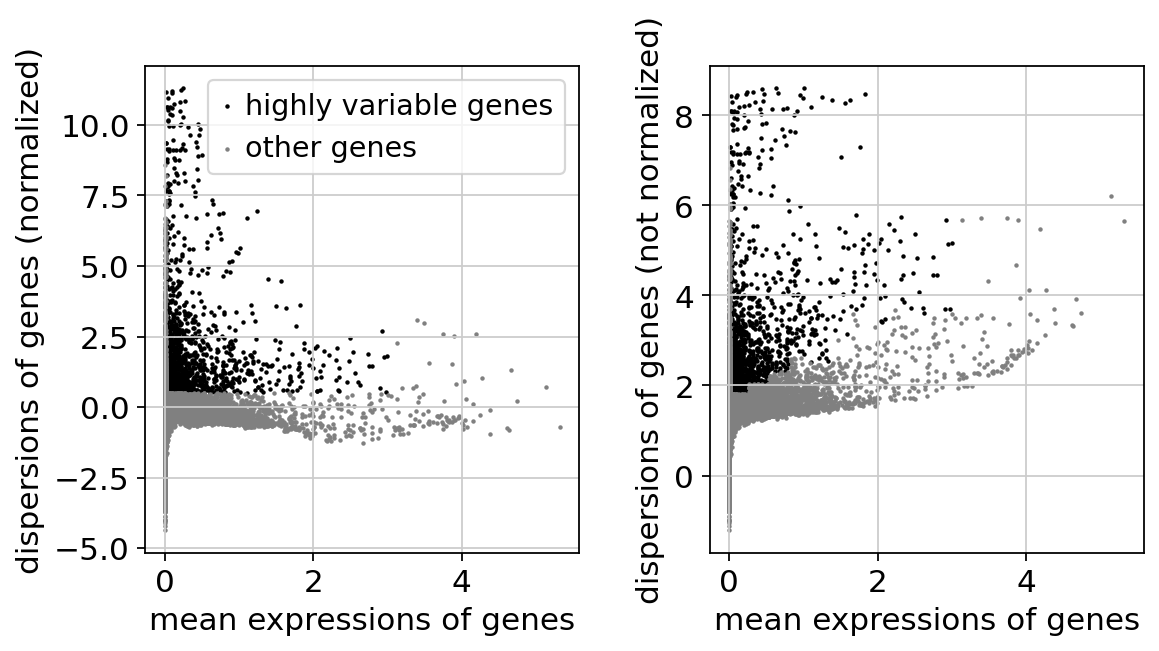

In [8]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [9]:
adata_filtered = adata[:, adata.var['highly_variable']]

In [10]:
sc.pp.regress_out(adata_filtered, ['percent_mito'])

regressing out ['percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:22:44)


In [11]:
sc.pp.scale(adata_filtered, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:58)


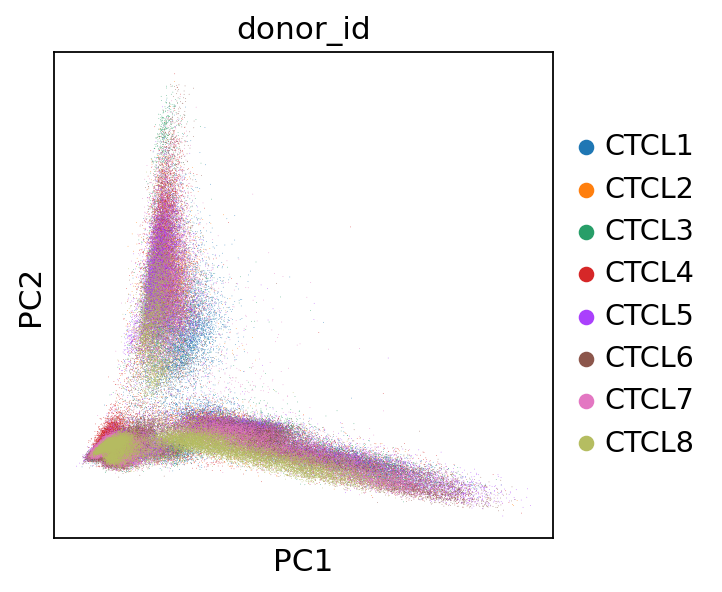

In [12]:
sc.tl.pca(adata_filtered, n_comps=50)
sc.pl.pca(adata_filtered, color = ['donor_id'])

#### harmony

In [13]:
adata_filtered_harmony = adata_filtered.copy()

In [14]:
#Set harmony variables
pca = np.array(adata_filtered_harmony.obsm["X_pca"])
batch = adata_filtered_harmony.obs['donor_id']
meta_data = adata_filtered_harmony.obs

#Run Harmony
ho = hm.run_harmony(pca, meta_data, ['donor_id'], theta = 3, random_state = 1234)
res = (pd.DataFrame(ho.Z_corr)).T
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

#Insert coordinates back into object
adata_filtered_harmony.obsm["X_pca_back"]= adata_filtered_harmony.obsm["X_pca"][:]
adata_filtered_harmony.obsm["X_pca"] = np.array(res)

2022-09-14 09:30:10,408 - harmonypy - INFO - Iteration 1 of 10
2022-09-14 09:37:06,722 - harmonypy - INFO - Iteration 2 of 10
2022-09-14 09:43:53,645 - harmonypy - INFO - Iteration 3 of 10
2022-09-14 09:50:38,018 - harmonypy - INFO - Iteration 4 of 10
2022-09-14 09:57:12,051 - harmonypy - INFO - Iteration 5 of 10
2022-09-14 10:01:08,916 - harmonypy - INFO - Converged after 5 iterations


In [15]:
sc.pp.neighbors(adata_filtered_harmony, n_neighbors=15, n_pcs=50, random_state = 1234)
sc.tl.umap(adata_filtered_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:06:33)


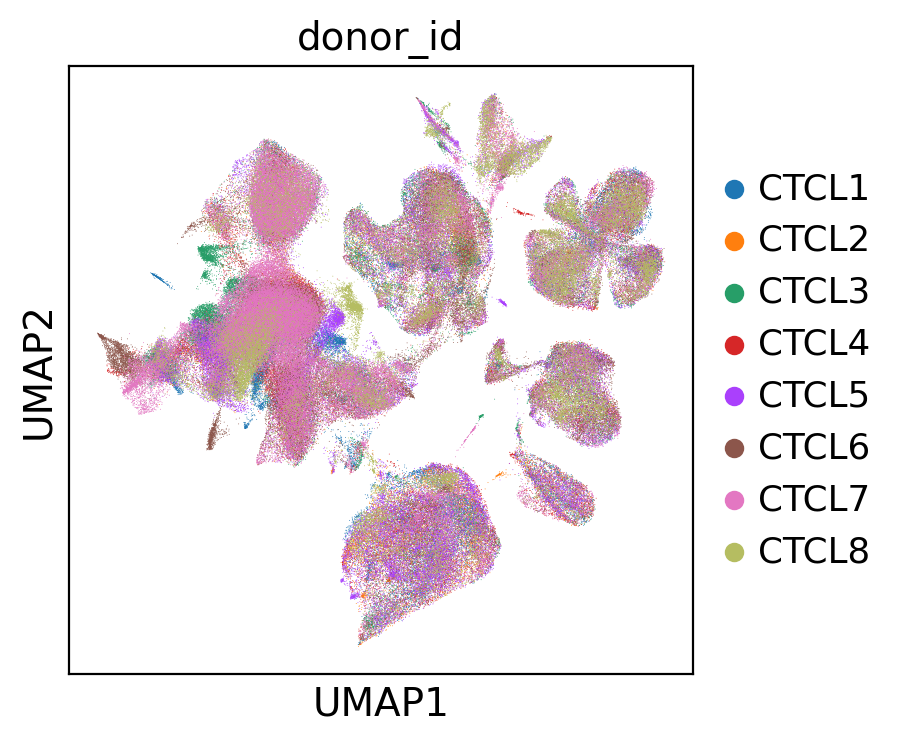

In [16]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['donor_id'])

In [6]:
save_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_processed_harmony_rmdou.h5ad'
adata_filtered_harmony.write(save_file)

In [2]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_processed_harmony_rmdou.h5ad'
adata_filtered_harmony = sc.read_h5ad(input_file)

In [17]:
sc.tl.leiden(adata_filtered_harmony, resolution=1.0, key_added='leiden_1.0')

running Leiden clustering
    finished: found 32 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:03:29)


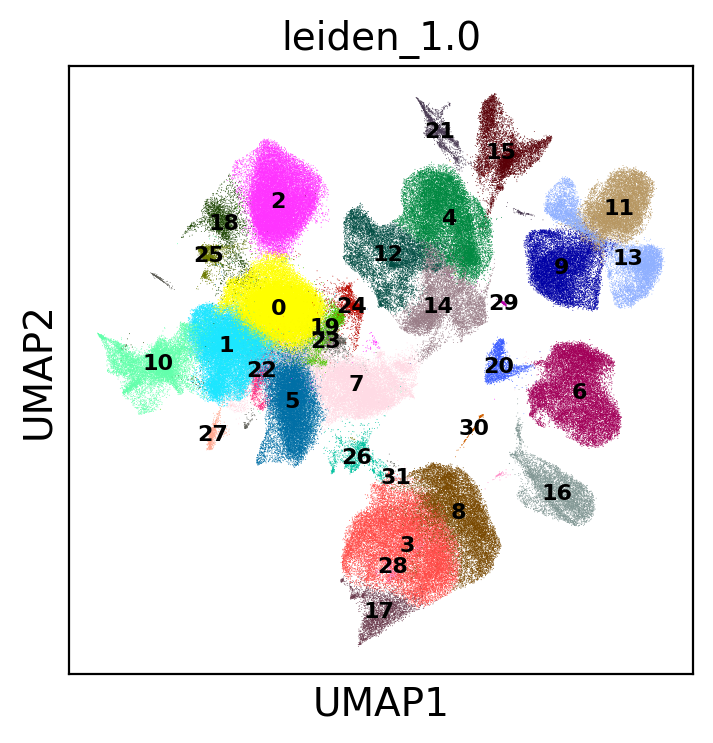

In [18]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['leiden_1.0'], legend_loc='on data', legend_fontsize=8)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:22:21)


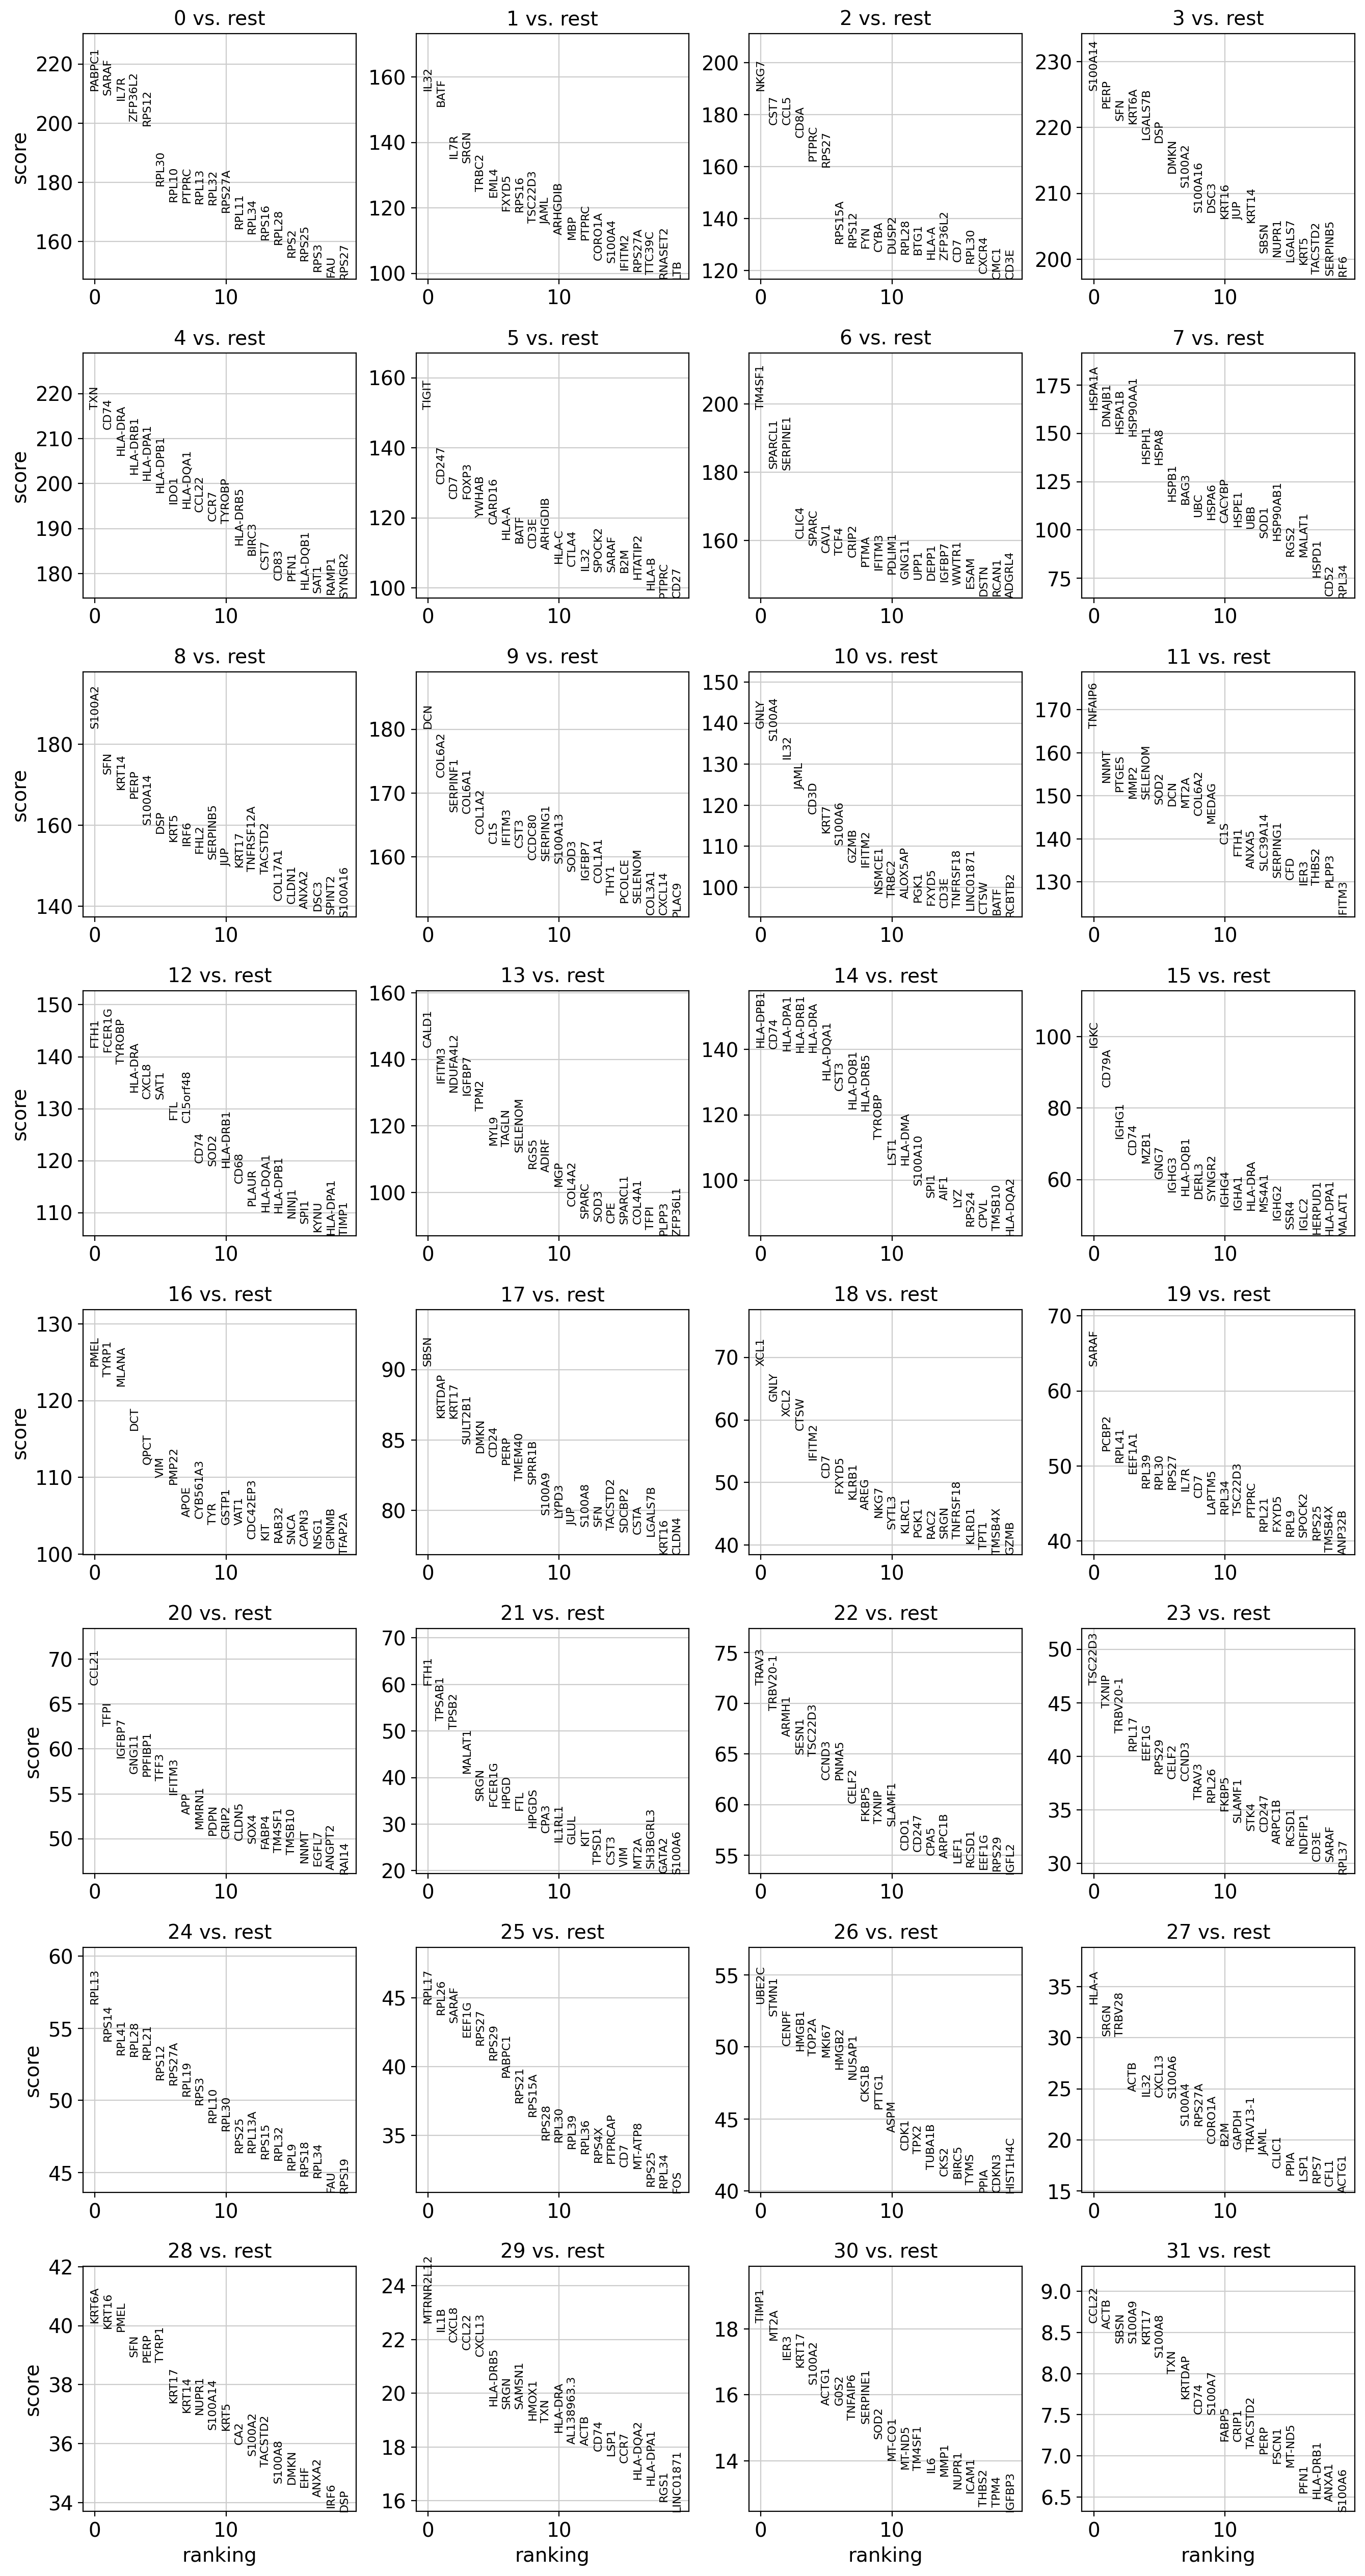

0_n  0_p       0_l      1_n  1_p       1_l     2_n  2_p       2_l  \
0   PABPC1  0.0  2.308842     IL32  0.0  2.605255    NKG7  0.0  5.362228   
1    SARAF  0.0  2.355733     BATF  0.0  3.043070    CST7  0.0  3.392318   
2     IL7R  0.0  3.097675     IL7R  0.0  2.395258    CCL5  0.0  5.384989   
3  ZFP36L2  0.0  2.700558     SRGN  0.0  2.196069    CD8A  0.0  5.715624   
4    RPS12  0.0  1.032029    TRBC2  0.0  2.397578   PTPRC  0.0  2.728156   
5    RPL30  0.0  0.819498     EML4  0.0  2.062976   RPS27  0.0  1.192082   
6    RPL10  0.0  0.745413    FXYD5  0.0  1.581141  RPS15A  0.0  0.860574   
7    PTPRC  0.0  2.407155    RPS16  0.0  0.927920   RPS12  0.0  0.869768   
8    RPL13  0.0  0.831277  TSC22D3  0.0  1.897995     FYN  0.0  2.537243   
9    RPL32  0.0  0.761834     JAML  0.0  2.550705    CYBA  0.0  1.946555   

       3_n  ...      28_l       29_n           29_p      29_l      30_n  \
0  S100A14  ...  6.714438  MTRNR2L12  7.741760e-109  5.094326     TIMP1   
1     PERP  ...  7.241849       IL1B  4.263283e-106  7.638256      MT2A   
2      SFN  ...  7.046659      CXCL8  2.004309e-102  6.470231      IER3   
3    KRT6A  ...  6.230776      CCL22  9.550439e-100  6.768942     KRT17   
4  LGALS7B  ...  5.479374     CXCL13   1.142432e-97  6.740934    S100A2   
5      DSP  ...  6.798260   HLA-DRB5   3.070728e-81  4.373681     ACTG1   
6     DMKN  ...  6.118612       SRGN   1.738431e-80  3.159355      G0S2   
7   S100A2  ...  6.476581     SAMSN1   2.133830e-80  3.980658   TNFAIP6   
8  S100A16  ...  4.948566      HMOX1   5.060258e-77  4.581691  SERPINE1   
9     DSC3  ...  5.411242        TXN   3.025087e-76  3.278224      SOD2   

           30_p      30_l    31_n          31_p      31_l  
0  1.961960e-69  4.896698   CCL22  1.810723e-13  6.927127  
1  1.072775e-65  3.940741    ACTB  1.810723e-13  3.124004  
2  2.279326e-61  4.401536    SBSN  3.401286e-13  6.433474  
3  7.132224e-60  5.307732  S100A9  3.401286e-13  6.467988  
4  3.985032e-56  4.903640   KRT17  3.401286e-13  6.443362  
5  7.448609e-52  2.109191  S100A8  1.114327e-12  6.417233  
6  7.448609e-52  4.614482     TXN  5.043184e-12  4.143485  
7  6.660234e-49  4.925097  KRTDAP  4.919057e-11  6.033862  
8  3.179560e-48  4.884179    CD74  1.726097e-10  4.430356  
9  3.094686e-45  3.414837  S100A7  1.726097e-10  5.916206  

[10 rows x 96 columns]

In [19]:
sc.tl.rank_genes_groups(adata_filtered_harmony, 'leiden_1.0', method = 'wilcoxon', n_genes = 200, use_raw = True)
sc.pl.rank_genes_groups(adata_filtered_harmony, n_genes=20, sharey=False)
result = adata_filtered_harmony.uns['rank_genes_groups']
groups = result['names'].dtype.names
markers = pd.DataFrame(
{group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj', 'logfoldchanges']})
markers.head(10)

In [23]:
mye_dict = {'0':'T-cell',
            '1':'T-cell', 
            '2':'T-cell',
            '3':'KC',
            '4':'APC',
            '5':'T-cell',
            '6':'V-Endo',
            '7':'T-cell',
            '8':'KC',
            '9':'Fibro',
            '10':'T-cell',
            '11':'Fibro',
            '12':'APC',
            '13':'Pericyte',
            '14':'APC',
            '15':'B/Plasma',
            '16':'Melanocyte',
            '17':'KC',
            '18':'NK/ILC',
            '19':'T-cell',
            '20':'L-Endo',
            '21':'Mast',
            '22':'T-cell',
            '23':'T-cell',
            '24':'T-cell',
            '25':'T-cell',
            '26':'T-cell',
            '27':'T-cell',
            '28':'KC',
            '29':'29',
            '30':'KC',
            '31':'KC',
           }
adata_filtered_harmony.obs['broad_cell_type'] = adata_filtered_harmony.obs['leiden_1.0'].map(mye_dict)
adata_filtered_harmony = adata_filtered_harmony[~adata_filtered_harmony.obs['broad_cell_type'].isin(['29'])]

In [24]:
col = ['#F35B92','#3E8D0E','#BAB1A7','#60528F',
 '#75CFC1','#BFD03F','#7982E3','#C2501E','grey','#EC6CDD',
 '#BFA829','#794FE0','#A1208F']

/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/anndata/_core/anndata.py:1229: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'broad_cell_type' as categorical


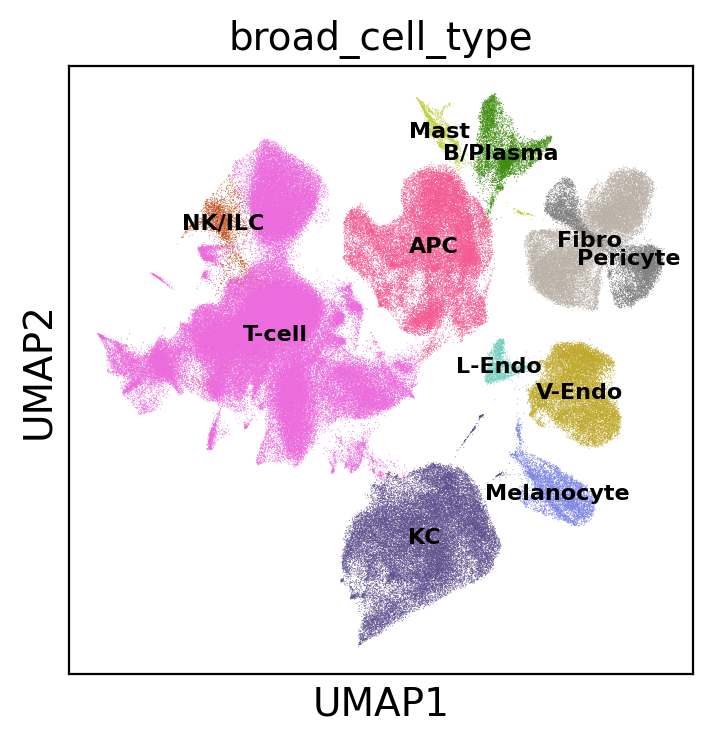

In [25]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['broad_cell_type'], legend_loc='on data', legend_fontsize=8, palette = col)

In [26]:
genes = ['CCR7','IDO1','CD79A','IGKC','LUM','DCN',
        'KRT14','KRTDAP','PDPN','TFF3','TPSAB1','TPSB2',
        'TYRP1','PMEL','NKG7','XCL1','RGS5','TAGLN',
        'CD3D','CD3E','PLVAP','PECAM1']

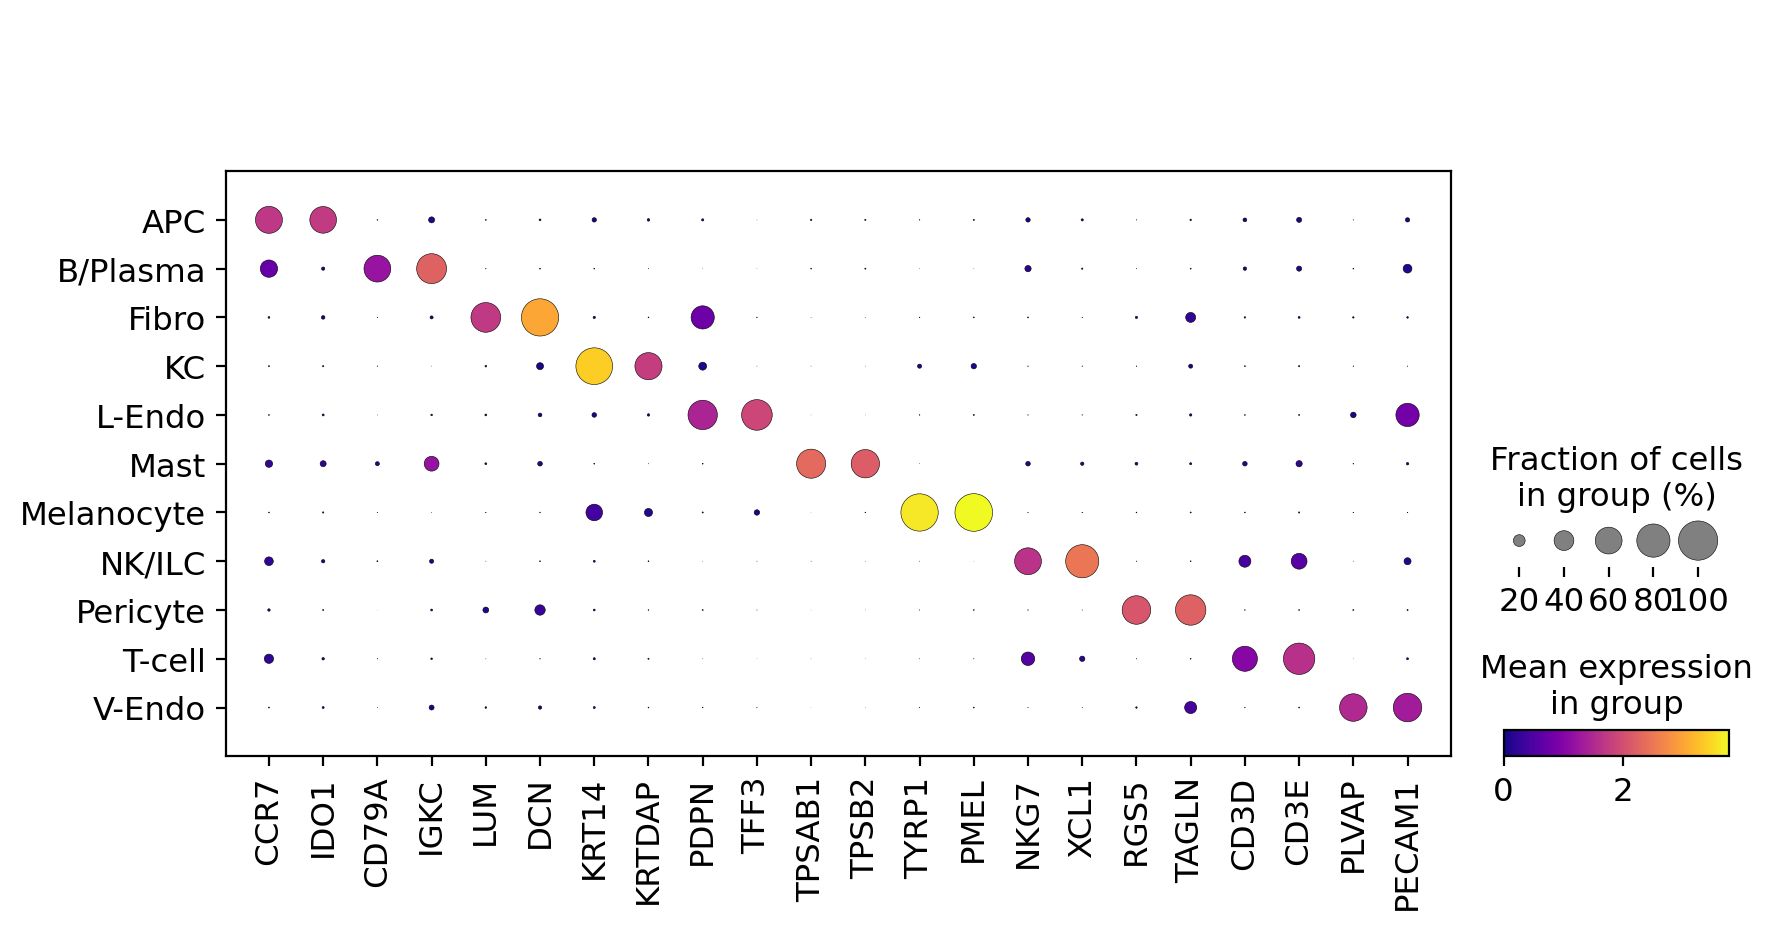

In [28]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
dp = sc.pl.dotplot(adata_filtered_harmony, genes, groupby='broad_cell_type',
                   dendrogram=False, use_raw=True, color_map='plasma')

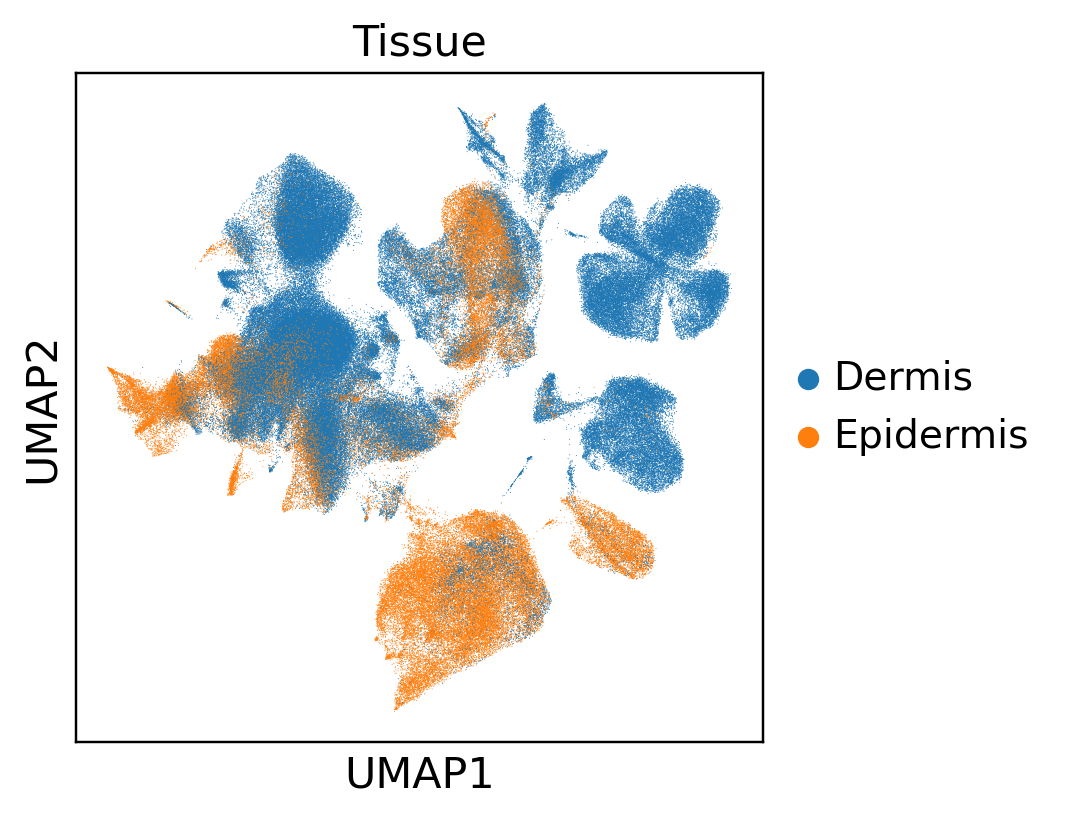

In [29]:
sc.settings.set_figure_params(dpi=110, facecolor='white')
#sc.pl.umap(adata_filtered_harmony_sub, color=['broad_cell_type'], legend_loc='on data', legend_fontsize=8)
sc.pl.umap(adata_filtered_harmony, color=['Tissue'])

In [69]:
save_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_processed_harmony_rmdou.h5ad'
adata_filtered_harmony.write(save_file)